# Capstone project

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Data cleaning / processing / language parsing

For this capstone project we will be using a dataset of newspaper articles found on Kaggle, taken from a wide variety of news sources. We will choose a subset of text consisting of 200 articles, with 10 different authors. Each author's corpus will contain 20 articles.
https://www.kaggle.com/snapcrack/all-the-news

In [1358]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import json
from time import time
from collections import Counter
from sklearn import ensemble
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, SpectralClustering, MeanShift, estimate_bandwidth

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, log_loss, make_scorer, normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize, normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import scikitplot.plotters as skplt

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

stopwords = stopwords.words('english')

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.16.4
Pandas version: 0.23.4
Seaborn version: 0.9.0


In [1241]:
df = pd.read_csv('datasets/all-the-news/articles1.csv')
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [1242]:
df.isnull().sum()

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64

In [1243]:
df = df.drop(['Unnamed: 0', 'url'], axis=1)
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [1244]:
df.isnull().sum()

id                0
title             0
publication       0
author         6306
date              0
year              0
month             0
content           0
dtype: int64

In [1245]:
df = df.dropna()
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [1246]:
df.isnull().sum()

id             0
title          0
publication    0
author         0
date           0
year           0
month          0
content        0
dtype: int64

Statistical Summary of Article Lengths
count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64


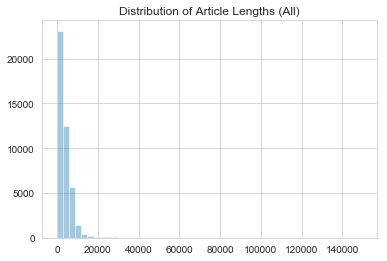

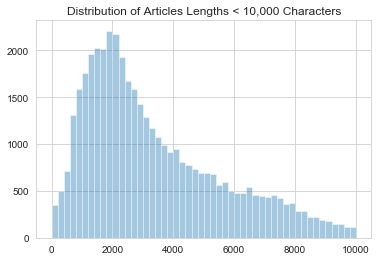

0     5607
1    27834
2    14018
3    12274
4     4195
dtype: int64

In [1247]:
lengths = pd.Series([len(x) for x in df.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths < 10000], kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()
lengths.head()

In [1248]:
df.describe()

,id,year,month
count,43694.000000,43694.000000,43694.000000
mean,42122.658283,2016.314666,5.484895
std,15340.887303,0.563555,3.351943
min,17283.000000,2012.000000,1.000000
25%,29695.250000,2016.000000,3.000000
50%,40632.500000,2016.000000,5.000000
75%,52731.750000,2017.000000,8.000000
max,73469.000000,2017.000000,12.000000


In [1249]:
lengths.describe()

count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64

In [1250]:
# Add lengths column to main dataframe
df['length'] = lengths
df.head()

,id,title,publication,author,date,year,month,content,length
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...,5607.0
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood...",27834.0
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",14018.0
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t...",12274.0
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ...",4195.0


In [1251]:
# Add variable to make counting easier during aggregate operations later on
# Just set each value to 1
df['count'] = 1
df.head()

,id,title,publication,author,date,year,month,content,length,count
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...,5607.0,1
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood...",27834.0,1
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",14018.0,1
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t...",12274.0,1
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ...",4195.0,1


In [1252]:
df.dtypes

id               int64
title           object
publication     object
author          object
date            object
year           float64
month          float64
content         object
length         float64
count            int64
dtype: object

In [1253]:
df.isnull().sum()

id                0
title             0
publication       0
author            0
date              0
year              0
month             0
content           0
length         4648
count             0
dtype: int64

In [1254]:
df = df.dropna()
df.head()

,id,title,publication,author,date,year,month,content,length,count
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...,5607.0,1
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood...",27834.0,1
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri...",14018.0,1
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t...",12274.0,1
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ...",4195.0,1


In [1255]:
df.isnull().sum()

id             0
title          0
publication    0
author         0
date           0
year           0
month          0
content        0
length         0
count          0
dtype: int64

In [1267]:
# First 10 authors with more than 20 articles
print(df.author.value_counts()[df.author.value_counts()>20][-10:])

Anne Barnard            22
Nicholas Fandos         21
Max Fisher              21
Patrick Healy           21
The Associated Press    21
Victor Mather           21
Amanda Jackson          21
Ashley Strickland       21
Carl Hulse              21
Ben Shapiro             21
Name: author, dtype: int64


In [1260]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles

# Make a list of the 10 chosen author names
names = df.author.value_counts()[df.author.value_counts() > 20][-10:].index.tolist()

print(names)

# DataFrame for articles of all chosen authors
data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = df[df.author == name][:20][['title', 'content', 'author']]
    # Append data to DataFrame
    data = data.append(articles)

data = data.reset_index().drop('index', 1)

['Anne Barnard', 'Nicholas Fandos', 'Max Fisher', 'Patrick Healy', 'The Associated Press', 'Victor Mather', 'Amanda Jackson', 'Ashley Strickland', 'Carl Hulse', 'Ben Shapiro']


In [1283]:
# Look for duplicates
print('Total articles:', data.shape[0])
print('Unique articles:', len(np.unique(data.index)))

# Number of authors
print('Unique authors:', len(np.unique(data.author)))
print('')
print('Articles by author:\n')

# Article counts by author
print(data.author.value_counts())

Total articles: 200
Unique articles: 200
Unique authors: 10

Articles by author:

Ashley Strickland       20
Amanda Jackson          20
Ben Shapiro             20
The Associated Press    20
Patrick Healy           20
Max Fisher              20
Victor Mather           20
Anne Barnard            20
Nicholas Fandos         20
Carl Hulse              20
Name: author, dtype: int64


In [1262]:
start_time = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store each author's spacy_doc object
authors_docs = {}

for name in names:
    # Corpus is all text written by a single author
    corpus = ""
    
    # Grab all text of current author, along 'content' column
    author_content = data.loc[data.author == name, 'content']
    
    # Add each article to overall corpus
    for article in author_content:
        corpus = corpus + article
        
    # Clean corpus and parse using Spacy
    doc = nlp(text_cleaner(corpus))
    
    # Store doc in dictionary
    authors_docs[name] = doc
        
    # Remove punctuation and stop words
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        
    # Return most common words of that author's corpus
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of common words
    for word in bow:
        common_words.append(word)

# Remove duplicates
common_words = set(common_words)
    
print('Total number of common words:', len(common_words))
print("Completed in %0.3fs" % (time() - start_time))

Total number of common words: 4224
done in 52.709s


In [1263]:
# Let's see how many words per author
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus has', len(v), ' words.')
    lengths.append(len(v))

Anne Barnard corpus contains 27970  words.
Nicholas Fandos corpus contains 20679  words.
Max Fisher corpus contains 31831  words.
Patrick Healy corpus contains 30283  words.
The Associated Press corpus contains 10346  words.
Victor Mather corpus contains 15587  words.
Amanda Jackson corpus contains 8949  words.
Ashley Strickland corpus contains 23598  words.
Carl Hulse corpus contains 22804  words.
Ben Shapiro corpus contains 20906  words.


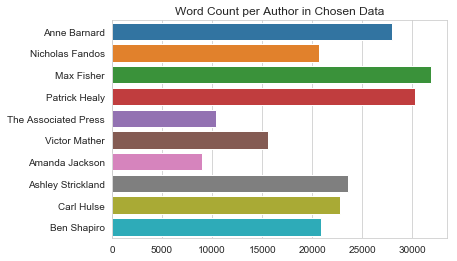

In [1264]:
#plt.figure(figsize=(15,10))
sns.barplot(x=lengths, y=names, orient='h')
plt.title('Word Count per Corpus')
plt.show()

In [1265]:
# Check for lowercase words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Total common words:', len(common_words))
print('Total lowercase common words:', np.sum([word.islower() for word in common_words]))

# Make all common words lowercase
common_words = [word.lower() for word in common_words]
print('Total lowercase common words (after converting):', np.sum([word.islower() for word in common_words]))

Count of all common_words: 4224
Count of lowercase common_words: 2962
Count of lowercase common_words (After Conversion): 4113


In [1266]:
# Remove words that might conflict with new features
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

In [1268]:
# Count how many times a common word appears in each article
bow_counts = pd.DataFrame()
for name in names:
    # Select 20 articles for each author
    articles = data.loc[data.author==name,:][:20]
    # Append articles to BOW dataframe
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Populate DataFrame with counts of every feature per article
start_time = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        # If lowercase word is found in common words, increment its BOW count
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every 20 articles
    if i % 20 == 0:
        if time()-start_time < 3600: # if less than an hour in seconds
            print("Article ", i, " completed after ", (time()-start_time)/60,' minutes.')
        else:
            print("Article ", i, " completed after ", (time()-start_time)/60/60,' hours.')

Article  0  done after  0.09414474964141846  minutes.
Article  20  done after  5.038539783159892  minutes.
Article  40  done after  10.048785698413848  minutes.
Article  60  done after  15.216902033487957  minutes.
Article  80  done after  20.644835166136424  minutes.
Article  100  done after  22.368789919217427  minutes.
Article  120  done after  25.067425433794657  minutes.
Article  140  done after  27.913091997305553  minutes.
Article  160  done after  32.89906223217646  minutes.
Article  180  done after  38.026613350709276  minutes.


In [1269]:
bow_counts.head(3)

,title,content,author,peace,half,outskirt,barack,gun,25,charge,...,lead,building,movie,leyva,room,quds,twinkies,draw,private,newborn
0,Amnesty Report Accuses Syria of Executing Thou...,"BEIRUT, Lebanon — The Syrian government has...",Anne Barnard,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,"Kazakh Capital, a Post-Soviet Creation, Is Gro...","ASTANA, Kazakhstan — The Astana Opera tower...",Anne Barnard,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,Resurgent Syrian Rebels Surprise Damascus With...,"BEIRUT, Lebanon — Syrian insurgents seized ...",Anne Barnard,3,1,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [1352]:
# Establish outcome and predictors
X = bow_counts.drop(['content','author','title'], 1)
y = bow_counts['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [1353]:
# Store overall results in two separate DataFrames
clust_metrics = ['Algorithm', 'Sample Size', 'Features', 'ARI', 'Silhouette']
model_metrics = ['Algorithm', 'Sample Size', 'Features', 'ARI', 'Cross-validation', 'Train Accuracy', 'Test Accuracy']

clustering = pd.DataFrame(columns=clust_metrics)
modeling = pd.DataFrame(columns=model_metrics)

# Clustering
## Find Optimal Clusters

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


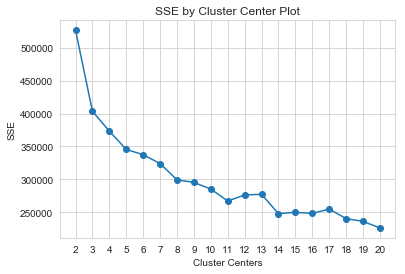

In [1354]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_train, 20)

In [1371]:
# Function to quickly evaluate clustering solutions
def evaluate_clust(data, target, clust, params, features, i):
    start_time = time()
    print('\n','-'*50,'\n',clust.__class__.__name__,'\n','-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clust, params, scoring=score, cv=5).fit(data, target)
    print("Best parameters:", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(data)

    ari = adjusted_rand_score(target, y_pred)
    performance.loc[i, 'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    sil = silhouette_score(data, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    performance.loc[i, 'Algorithm'] = clust.__class__.__name__
    performance.loc[i, 'Sample Size'] = len(data)
    performance.loc[i, 'Features'] = features
    
    # Print contingency matrix
    crosstab = pd.crosstab(target, y_pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    print(time()-start_time, "seconds.")

## Clustering: Train Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 20, 'n_init': 20, 'precompute_distances': False}
Adjusted Rand-Index: 0.243
Silhouette Score: 0.006


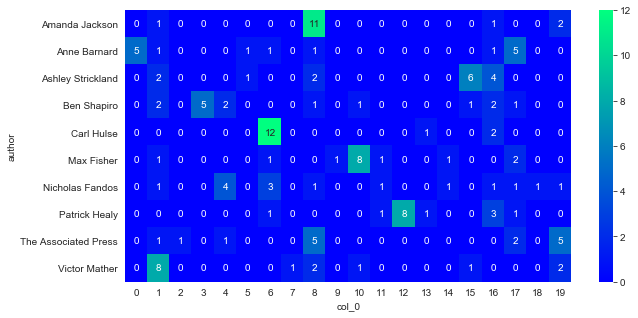

137.73071384429932 seconds.


In [1372]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_clust(X_train, y_train, clust, params, features='BOW', i=0)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.009
Silhouette Score: 0.174


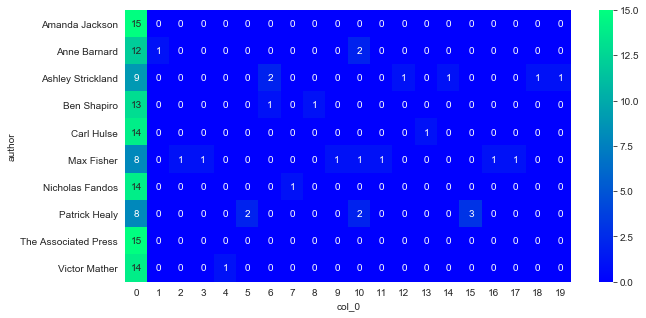

25.108008861541748 seconds.


In [1373]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_clust(X_train, y_train, clust, params, features='BOW', i=1)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.7, 'max_iter': 200}
Adjusted Rand-Index: 0.162
Silhouette Score: 0.065


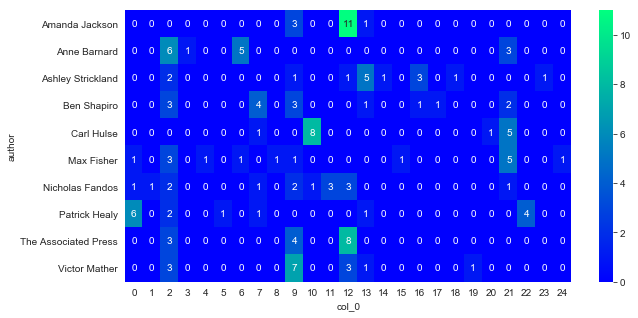

2.57197904586792 seconds.


In [1374]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_clust(X_train, y_train, clust, params, features='BOW', i=2)

## Clustering: Test Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': False}
Adjusted Rand-Index: 0.105
Silhouette Score: -0.006


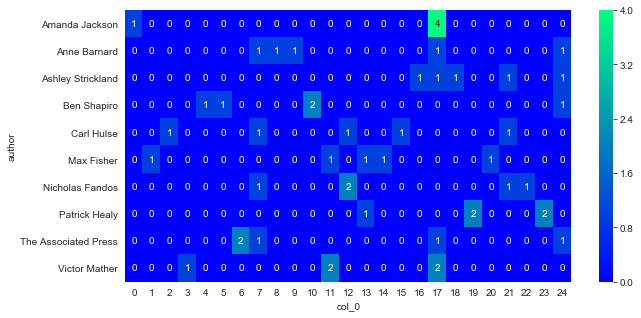

44.84340190887451 seconds.


In [1375]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_clust(X_test, y_test, clust, params, features='BOW', i=0)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.020
Silhouette Score: 0.201


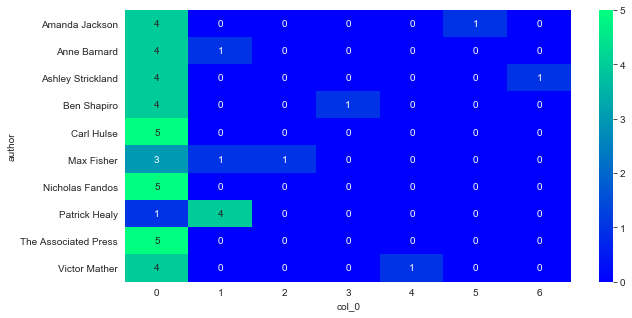

2.700531005859375 seconds.


In [1376]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_clust(X_test, y_test, clust, params, features='BOW', i=1)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.126
Silhouette Score: 0.135


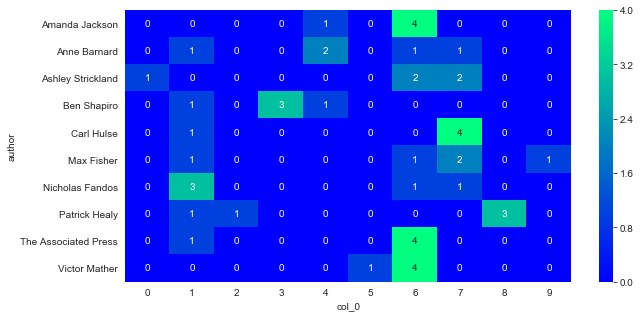

3.032698154449463 seconds.


In [1377]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_clust(X_test, y_test, clust, params, features='BOW', i=2)

# Modeling
We can create a simple function to run our model and store results in a dataframe, which will allow us to easily compare results at the end.

In [1368]:
def optimize_model(clf, params, features, i):
    start_time = time()
    
    # Print classifier type
    print('\n', '-'*50, '\n', clf.__class__.__name__, '\n', '-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clf, params, scoring=score, cv=5).fit(X, y)
    
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:", search.best_params_)

    # Run cross-validation
    cv = cross_val_score(X=X, y=y,estimator=best, cv=5)
    print("\nCross-validation scores:", cv)
    print("\nMean cross-validation score:", cv.mean())
    performance.loc[i, 'Cross-validation'] = cv.mean() 
    
    # Calculate training accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train,y=y_train)
    performance.loc[i, 'Train Accuracy'] = train 
    print("\nTrain Set Accuracy Score:", train)

    # Calculate test accuracy
    test = best.score(X=X_test, y=y_test)
    performance.loc[i, 'Test Accuracy'] = test 
    print("\nTest Set Accuracy Score:", test)
    
    y_pred = best.predict(X_test)

    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i, 'ARI'] = ari 
    print("\nAdjusted Rand-Index: %.3f" % ari)

    
    print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    
    performance.loc[i,'Data Size'] = len(X_train)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clf.__class__.__name__
    print(time()-start_time, 'seconds.')

### Logistic Regression


 -------------------------------------------------- 
 LogisticRegression 
 --------------------------------------------------
Best parameters: {'C': 0.7, 'penalty': 'l2', 'solver': 'lbfgs'}

Cross-validation scores: [0.775 0.85  0.825 0.775 0.65 ]

Mean cross-validation score: 0.775

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.82

Adjusted Rand-Index: 0.622
                      precision    recall  f1-score   support

      Amanda Jackson       0.57      0.80      0.67         5
        Anne Barnard       1.00      1.00      1.00         5
   Ashley Strickland       0.75      0.60      0.67         5
         Ben Shapiro       0.83      1.00      0.91         5
          Carl Hulse       1.00      1.00      1.00         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.80      0.80      0.80         5
       Patrick Healy       1.00      0.60      0.75         5
The Associated Press       0.60      0.60      0.60         5
    

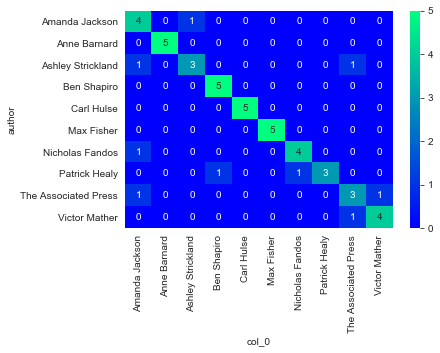

253.00225615501404 seconds.


In [1369]:
params = [{
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    multi_class='auto'
)

optimize_model(clf=clf, params=params, features='BOW', i=0)


 -------------------------------------------------- 
 RandomForestClassifier 
 --------------------------------------------------
Best parameters: {'n_estimators': 20}

Cross-validation scores: [0.7   0.675 0.65  0.675 0.7  ]

Mean cross-validation score: 0.68

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.7

Adjusted Rand-Index: 0.438
                      precision    recall  f1-score   support

      Amanda Jackson       0.44      0.80      0.57         5
        Anne Barnard       1.00      1.00      1.00         5
   Ashley Strickland       0.50      0.60      0.55         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       0.57      0.80      0.67         5
          Max Fisher       0.71      1.00      0.83         5
     Nicholas Fandos       0.67      0.40      0.50         5
       Patrick Healy       1.00      0.60      0.75         5
The Associated Press       1.00      0.20      0.33         5
       Victor Mather       0

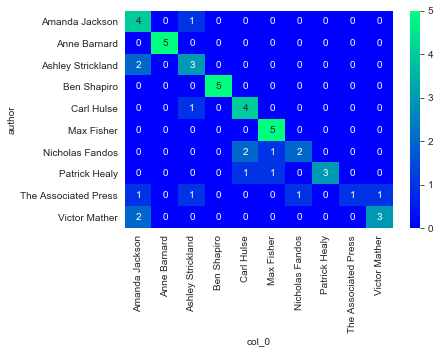

8.417227029800415 seconds.


In [1370]:
params = [{
    'n_estimators': [10, 15, 20]
}]

clf = RandomForestClassifier(
    n_jobs=-1, # Use all CPU
)

optimize_model(clf=clf, params=params, features='BOW', i=1)